In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal


def compute_gradients(img):
    """
    Compute the horizontal and vertical gradients of an input grayscale image using the Sobel operator.

    Args:
    - img: input grayscale image.

    Returns:
    - Ex: horizontal gradient.
    - Ey: vertical gradient.
    """
    Ex = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Ey = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return Ex, Ey


def find_corners(local_max):
    """
    Find the coordinates of corners detected using the Harris corner detection algorithm.

    Args:
    - local_max: binary image containing the detected corner points.

    Returns:
    - corners: Nx2 array of (x,y) corner coordinates.
    """
    corners = np.argwhere(local_max > 0)
    return corners


def harris_corner_detector(img, window_size=3, std=1, k=0.05, threshold=0.01):
    """
    Detect corners in an input grayscale image using the Harris corner detection algorithm.

    Args:
    - img: input grayscale image.
    - window_size: size of the Gaussian smoothing window.
    - std: standard deviation of the Gaussian smoothing window.
    - k: Harris corner constant.
    - threshold: threshold value for non-maximum suppression.

    Returns:
    - corners: Nx2 array of (x,y) corner coordinates.
    """
    # Compute image gradients
    Ex, Ey = compute_gradients(img)

    # Compute products of derivatives
    E2X = Ex ** 2
    E2Y = Ey ** 2
    Exy = Ex * Ey

    # Gaussian window for smoothing
    w_mask = signal.windows.gaussian(window_size ** 2, std, sym=True)
    w_mask = w_mask.reshape((window_size, window_size))

    # Sums of products, using Gaussian smoothing
    S2X = signal.convolve2d(E2X, w_mask)
    S2Y = signal.convolve2d(E2Y, w_mask)
    Sxy = signal.convolve2d(Exy, w_mask)

    # Calculate corner response
    det = (S2X * S2Y) - (Sxy ** 2)
    trace = S2X + S2Y
    R = det - k * (trace ** 2)

    # Non-maximum suppression    
    _, R = cv2.threshold(R, threshold*R.max(), 255, 0)
    # Find local maxima in the image
    local_max = (R == scipy.ndimage.maximum_filter(R, size=3))

    # Apply threshold to filter out weak maxima
    local_max[R < threshold] = False

    # Set non-maximum values to zero
    corners = R.copy()
    corners[np.logical_not(local_max)] = 0
    corners = corners[1:-1,1:-1]

    return corners, img + corners


# def get_window(img, h, w, size):
#     """
#     Extract a window of a specified size around a specified pixel location in an image.

#     Args:
#     - img: input image.
#     - h: row index of the pixel location.
#     - w: column index of the pixel location.
#     - size: size of the window.

#     Returns:
#     - window: window of the input image.
#     """
#     pad_size = size // 2
#     pad_img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size)))
#     window = pad_img[h + pad_size: h + pad_size +
#                      size, w + pad_size: w + pad_size + size]
#     return window
def get_window(img,h,w,n): 
    #gets nxn window of image centered at corner coords 
    #used for NCC calculation 
    pad_img = np.pad(img, ((n,n), (n,n)))
    window = pad_img[h+n : h+2*n, w+n : w+2*n]
    return window 

def match_corners(img1, img2, corners1, corners2, window_size=5, threshold=0.99):
    """
    Find corresponding corners between two images using normalized cross-correlation (NCC).Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.
    - corners1: Nx2 array of (x,y) corner coordinates in the first image.
    - corners2: Nx2 array of (x,y) corner coordinates in the second image.
    - window_size: size of the NCC window.
    - threshold: threshold value for NCC matching.

    Returns:
    - matches: Nx5 array of (x1,y1,x2,y2,NCC) matches, where (x1,y1) and (x2,y2) are the corresponding
    corner coordinates in the two images, and NCC is the normalized cross-correlation value.
    """
    matches = []
    corners1 = find_corners(corners1)
    corners2 = find_corners(corners2)
    for i in range(len(corners1)):
        h1, w1 = corners1[i]
        window1 = get_window(img1, h1, w1, window_size)
        best_match = None
        for j in range(len(corners2)):
            h2, w2 = corners2[j]
            window2 = get_window(img2, h2, w2, window_size)
            ncc = np.sum((window1 - np.mean(window1)) * (window2 - np.mean(window2))) / (
                np.std(window1) * np.std(window2) * window_size ** 2)
            if best_match is None or ncc > best_match[-1]:
                best_match = [h1, w1, h2, w2, ncc]
        if best_match[-1] >= threshold:
            matches.append(best_match)
    matches = np.array(matches)
    return matches


def plot_correspondences(img1, img2, matches):
    """
    Plot the corresponding corners between two images as lines.
    Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.
    - matches: Nx5 array of (x1,y1,x2,y2,NCC) matches, where (x1,y1) and (x2,y2) are the corresponding
    corner coordinates in the two images, and NCC is the normalized cross-correlation value.

    Returns:
    - None
    """
    h_offset = img1.shape[0]
    w_offset = img2.shape[1]
    matched_imgs = np.hstack([img1, img2])
    plt.imshow(matched_imgs, cmap='gray')
    for i in range(matches.shape[0]):
        if matches[i, -1] >= 0.99:
            plt.plot([matches[i, 1], matches[i, 3] + w_offset],
                     [matches[i, 0], matches[i, 2]], 'r-', linewidth=0.5)
    plt.show()


def RANSAC(img1, img2):
    """
    Apply the Random Sample Consensus (RANSAC) algorithm to estimate a homography matrix between two images.
    Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.

    Returns:
    - M: 3x3 homography matrix.
    """
    # Detect SIFT keypoints and extract descriptors
    sift = cv2.SIFT_create()
    img1 = cv2.normalize(img1, None, 0,255, cv2.NORM_MINMAX).astype('uint8')
    img2 = cv2.normalize(img2, None, 0,255, cv2.NORM_MINMAX).astype('uint8')
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match keypoints using FLANN matcher
    FLANN_INDEX_KDTREE = 0

    # Set FLANN matcher parameters
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to filter out false matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Apply RANSAC algorithm to estimate homography matrix
    src_pts = np.float32(
        [kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # plot matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    plt.imshow(img3), plt.show()

    return M


def warp(img1, img2, H):
    """
    Warp the first image to the perspective of the second image using a homography matrix.
    Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.
    - H: 3x3 homography matrix.

    Returns:
    - warped: output warped grayscale image.
    """
    # Calculate output image dimensions and warp the first image
    end_h = img1.shape[0]
    end_w = img1.shape[1] + img2.shape[1]
    warped = cv2.warpPerspective(img1, H, (end_w, end_h))

    # Copy the second image to the output image
    warped[0:img2.shape[0], 0:img2.shape[1]] = img2

    return (end_w, end_h), warped


def blend(img1, img2):
    """
    Blend two images using alpha blending.
    Args:
    - img1: first input grayscale image.
    - img2: second input grayscale image.

    Returns:
    - blended: output blended grayscale image.
    """
    alpha = 0.5
    beta = 1 - alpha
    blended = cv2.addWeighted(img1, alpha, img2, beta, 0.0)
    # blended = cv2.addWeighted(img1, alpha, img2, beta, 0)

    return blended


# def warp_and_blend(img1, img2, H):
#     """
#     Warp the first image to the perspective of the second image using a homography matrix,
#     and blend the two images to create a mosaic.

#     Args:
#     - img1: first input grayscale image.
#     - img2: second input grayscale image.
#     - H: 3x3 homography matrix.

#     Returns:
#     - mosaic: output mosaic grayscale image.
#     """
#     # Calculate output image dimensions and warp the first image
#     end_h = img1.shape[0]
#     end_w = img1.shape[1] + img2.shape[1]
#     warped = cv2.warpPerspective(img1, H, (end_w, end_h))

#     # Blend the two images to create a mosaic
#     alpha = 0.5
#     beta = 1 - alpha
#     blended = cv2.addWeighted(warped[:, 0:img2.shape[1]], alpha, img2, beta, 0)
#     mosaic = np.hstack([blended, warped[:, img2.shape[1]:]])

#     return mosaic


In [54]:
hallway_path = "./DanaHallWay1"
office_path = "./DanaOffice"
office_files = [filename for filename in sorted(os.listdir(office_path)) if os.path.isfile(os.path.join(office_path, filename))]
#1) read in 2 imgs (if img size is too large --> reduce, and document scale factor used)
#Dana Office images: 
office_images = []    
for i in range(0, len(office_files)): 
    img = cv2.imread(os.path.join(office_path, office_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    office_images.append(gray_img)

office_images = np.array(office_images)
print(office_images.shape)

#Dana Hallway images: 
hallway_files = [filename for filename in sorted(os.listdir(hallway_path)) if os.path.isfile(os.path.join(hallway_path, filename))]

hallway_imgs = []    
for i in range(0, len(hallway_files)): 
    img = cv2.imread(os.path.join(hallway_path, hallway_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    hallway_imgs.append(gray_img)

hallway_files = np.array(hallway_imgs)
print(hallway_files.shape)

(10, 340, 512)
(3, 340, 512)


In [ ]:
np.set_printoptions(threshold=10000) 
np.set_printoptions(linewidth=10000) 
np.set_printoptions(threshold=1e6) 

(340, 512)


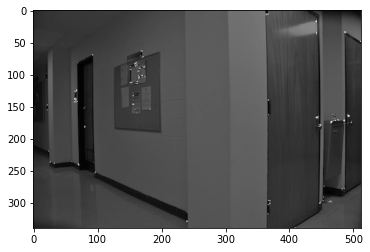

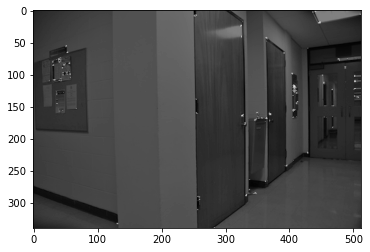

In [95]:
# find Harris corners in the hallway image
print(hallway_files[0].shape)
corners1, img1_corners = harris_corner_detector(hallway_files[0])
corners2, img2_corners = harris_corner_detector(hallway_files[1])
# plot the images
plt.figure()
plt.imshow(img1_corners, cmap='gray')
plt.figure()
plt.imshow(img2_corners, cmap='gray')

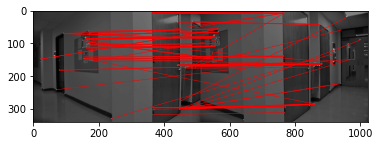

In [56]:
correspondences = match_corners(img1_corners, img2_corners, corners1, corners2)
plot_correspondences(img1_corners, img2_corners, correspondences)

In [301]:
import numpy as np

def warpImage(inputIm, refIm, H):
    """ Warps Input Image onto the Reference Image using the homography matrix
    H via inverse warp.
    Args:
        inputIm (ndarray): Image to be warped.
        refIm (ndarray): Reference Image.
        H (type): Description of parameter `H`.

    Returns:
        (ndarray, ndarray): Returns the warped version of the input image and
        the warped input image on the reference image.

    """

    H_inv = np.linalg.inv(H)
    inputH, inputW = inputIm.shape
    outputH, outputW = refIm.shape
    min_x = float("inf")
    min_y = float("inf")
    max_x = float("-inf")
    max_y = float("-inf")
    cornersi =  [(0,0), (inputH, inputW), (0, inputW), (inputH, 0)]
    cornerso =  [(0,0), (inputH, inputW), (0, inputW), (inputH, 0)]
    for i,j in cornersi:
        x, y, w = np.matmul(H, [j , i, 1])
        x = x/w
        y = y/w
        if x > max_x:
            max_x = int(x)
        if x < min_x:
            min_x = int(x)
        if y > max_y:
            max_y = int(y)
        if y < min_y:
            min_y = int(y)
    warpIm = np.zeros((max_y - min_y,max_x - min_x))
    for i in range(0, max_x - min_x):
        for j in range (0, max_y - min_y):
            x, y, w = np.matmul(H_inv, [i + min_x, j + min_y, 1])
            x = int(x/w)
            y = int(y/w)
            intensity = 0
            if not (y < 0 or y >= inputH or x < 0 or x >= inputW):
                intensity = inputIm[y, x]
            warpIm[j, i] = intensity/255
    oldx = min_x
    oldy = min_y
    oldmx = max_x
    oldmy = max_y
    for i,j in cornerso:
        if j > max_x:
            max_x = int(j)
        if j < min_x:
            min_x = int(j)
        if i > max_y:
            max_y = int(i)
        if i < min_y:
            min_y = int(i)
    mergeIm = np.zeros(((max_y - min_y),(max_x - min_x)))
    for i in range(min_x, max_x):
        for j in range (min_y, max_y):
            intensity = 0
            if not (j < oldy or j >= oldmy or i < oldx or i >= oldmx):
                intensity = warpIm[j - oldy, i - oldx]
                if intensity == 0.0:
                    if not (j < 0 or j >= outputH or i < 0 or i >= outputW):
                        intensity = refIm[j, i]/255
            else:
                if not (j < 0 or j >= outputH or i < 0 or i >= outputW):
                    intensity = refIm[j, i]/255
            mergeIm[j - min_y, i- min_x] = intensity

    return (warpIm, mergeIm)


In [324]:
def warp(imageA, imageB, H):
    result = cv2.warpPerspective(imageA, H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    # plot
    plt.figure()
    plt.imshow(result, cmap='gray')

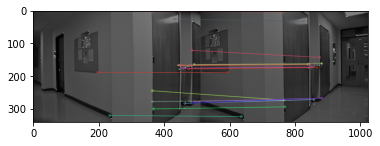

[[ 1.25653549e+00  1.34370641e-02 -1.59033882e+02]
 [ 7.12957250e-02  1.14974548e+00 -2.25808894e+01]
 [ 5.05641258e-04  4.63374428e-06  1.00000000e+00]]


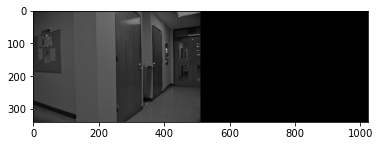

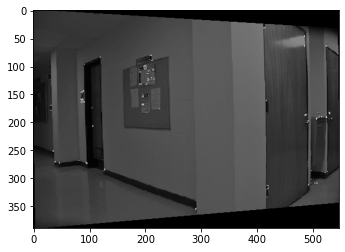

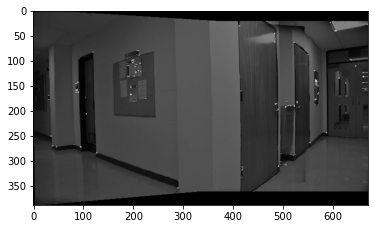

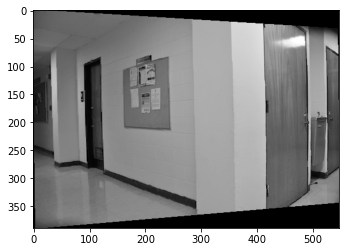

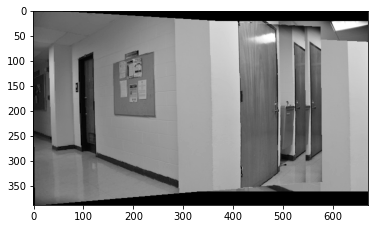

In [326]:
M = RANSAC(img1_corners, img2_corners)
print(M)
warp(img1_corners, img2_corners, M)
warpIm, mergeIm = warpImage(img1_corners,img2_corners, M)

plt.figure()
plt.imshow(warpIm, cmap='gray')

plt.figure()
plt.imshow(mergeIm, cmap='gray')

warpIm, mergeIm = warpImage(hallway_files[0],hallway_files[1], M)

plt.figure()
plt.imshow(warpIm, cmap='gray')

plt.figure()
plt.imshow(mergeIm, cmap='gray')
